<a href="https://colab.research.google.com/github/KESAVE8604-droid/kesaverdhen-hybrid-movie-recommender/blob/main/notebooks/Phase2_ContentModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Phase 2 — Content-Based TF-IDF Model
🎯 Objective

Build a content-based recommender that suggests movies similar in description (title + genres + year).

We’ll represent each movie by text features and compute cosine similarity between them.

In [1]:
#Step 1 — Import Libraries and Load Clean Data
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity

import joblib

# Path to your cleaned file (from Phase 1)
path = "/content/drive/MyDrive/MovieRecommender/movielens_cleaned.csv"

movies_df = pd.read_csv(path)
print("✅ Loaded dataset:", movies_df.shape)
movies_df.head()


✅ Loaded dataset: (1000209, 12)


,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Genres,Year,Clean_Title
0,1,1193,5,2000-12-31 22:12:40,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),['Drama'],1975,One Flew Over the Cuckoo's Nest
1,1,661,3,2000-12-31 22:35:09,F,1,10,48067,James and the Giant Peach (1996),"['Animation', ""Children's"", 'Musical']",1996,James and the Giant Peach
2,1,914,3,2000-12-31 22:32:48,F,1,10,48067,My Fair Lady (1964),"['Musical', 'Romance']",1964,My Fair Lady
3,1,3408,4,2000-12-31 22:04:35,F,1,10,48067,Erin Brockovich (2000),['Drama'],2000,Erin Brockovich
4,1,2355,5,2001-01-06 23:38:11,F,1,10,48067,"Bug's Life, A (1998)","['Animation', ""Children's"", 'Comedy']",1998,"Bug's Life, A"


In [2]:
#Step 2 — Prepare Combined Metadata Field


# Convert genres to strings safely
movies_df['Genres'] = movies_df['Genres'].astype(str)

# Convert year to string explicitly to avoid TypeError
movies_df['Year'] = movies_df['Year'].fillna('').astype(str)

# Combine text columns into a single metadata string
movies_df['Metadata'] = (
    movies_df['Clean_Title'].astype(str) + " " +
    movies_df['Genres'] + " " +
    movies_df['Year']
)

# Remove punctuation and convert to lowercase
movies_df['Metadata'] = movies_df['Metadata'].str.replace('[^a-zA-Z0-9 ]', ' ', regex=True).str.lower()

# Preview
movies_df[['Clean_Title', 'Metadata']].head(10)



,Clean_Title,Metadata
0,One Flew Over the Cuckoo's Nest,one flew over the cuckoo s nest drama 1975
1,James and the Giant Peach,james and the giant peach animation child...
2,My Fair Lady,my fair lady musical romance 1964
3,Erin Brockovich,erin brockovich drama 2000
4,"Bug's Life, A",bug s life a animation children s com...
5,"Princess Bride, The",princess bride the action adventure c...
6,Ben-Hur,ben hur action adventure drama 1959
7,"Christmas Story, A",christmas story a comedy drama 1983
8,Snow White and the Seven Dwarfs,snow white and the seven dwarfs animation ...
9,"Wizard of Oz, The",wizard of oz the adventure children s ...


In [3]:
# Check existing columns
print("Current columns in movies_df:")
print(movies_df.columns)

# If 'Metadata' column is missing, recreate it
if 'Metadata' not in movies_df.columns:
    print("\n'Recreating Metadata column...'")

    movies_df['Genres'] = movies_df['Genres'].astype(str)
    movies_df['Year'] = movies_df['Year'].fillna('').astype(str)

    movies_df['Metadata'] = (
        movies_df['Clean_Title'].astype(str) + " " +
        movies_df['Genres'] + " " +
        movies_df['Year']
    )

    movies_df['Metadata'] = movies_df['Metadata'].str.replace('[^a-zA-Z0-9 ]', ' ', regex=True).str.lower()
    print("✅ Metadata column created successfully!")

# Verify the new column
movies_df[['Clean_Title', 'Metadata']].head(5)


Current columns in movies_df:
Index(['UserID', 'MovieID', 'Rating', 'Timestamp', 'Gender', 'Age',
       'Occupation', 'Zip-code', 'Title', 'Genres', 'Year', 'Clean_Title',
       'Metadata'],
      dtype='object')


,Clean_Title,Metadata
0,One Flew Over the Cuckoo's Nest,one flew over the cuckoo s nest drama 1975
1,James and the Giant Peach,james and the giant peach animation child...
2,My Fair Lady,my fair lady musical romance 1964
3,Erin Brockovich,erin brockovich drama 2000
4,"Bug's Life, A",bug s life a animation children s com...


In [4]:

# Step 3 — Create TF-IDF Vector Matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the metadata column
tfidf_matrix = tfidf.fit_transform(movies_df['Metadata'])

print("✅ TF-IDF Matrix Created!")
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)


✅ TF-IDF Matrix Created!
TF-IDF Matrix Shape: (1000209, 4174)


In [5]:
# ✅ Rebuild TF-IDF + Compute Cosine Similarity

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Make sure Metadata column exists
if 'Metadata' not in movies_df.columns:
    print("⚠️ 'Metadata' column missing — recreating it...")
    movies_df['Genres'] = movies_df['Genres'].astype(str)
    movies_df['Year'] = movies_df['Year'].fillna('').astype(str)
    movies_df['Metadata'] = (
        movies_df['Clean_Title'].astype(str) + " " +
        movies_df['Genres'] + " " +
        movies_df['Year']
    )
    movies_df['Metadata'] = movies_df['Metadata'].str.replace('[^a-zA-Z0-9 ]', ' ', regex=True).str.lower()

# (Optional but recommended) keep only unique movies
movies_unique = movies_df.drop_duplicates(subset=['MovieID']).reset_index(drop=True)

# Build TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(movies_unique['Metadata'])

print("✅ TF-IDF Matrix Shape:", tfidf_matrix.shape)

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print("✅ Cosine Similarity Matrix Shape:", cosine_sim.shape)


✅ TF-IDF Matrix Shape: (3706, 4174)
✅ Cosine Similarity Matrix Shape: (3706, 3706)


In [6]:
from sklearn.metrics.pairwise import cosine_similarity
# Step 4 — Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print("✅ Cosine Similarity Matrix Shape:", cosine_sim.shape)


✅ Cosine Similarity Matrix Shape: (3706, 3706)


In [11]:
# Step 5 — Define Function to Get Similar Movies

# Create an index mapping from movie title to index
indices = pd.Series(movies_unique.index, index=movies_unique['Clean_Title'].str.lower()).drop_duplicates()

def get_similar_movies(movie_title, top_n=10):
    movie_title = movie_title.lower().strip()

    # Check if movie exists in index
    if movie_title not in indices:
        print("❌ Movie not found in dataset.")
        return pd.DataFrame(columns=['Clean_Title', 'Genres', 'Year'])

    # Get index of the movie
    idx = indices[movie_title]

    # Get pairwise similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort by similarity score (descending)
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Select top N most similar movies (skip first = the same movie)
    top_indices = [i[0] for i in sim_scores[1:top_n+1]]

    # Return top similar movies
    similar_movies = movies_unique.iloc[top_indices][['Clean_Title', 'Genres', 'Year']].reset_index(drop=True)

    return similar_movies


In [14]:
#Step 6 — Test Your Recommender
get_similar_movies("Toy Story", top_n=10)


,Clean_Title,Genres,Year
0,Toy Story 2,"['Animation', ""Children's"", 'Comedy']",1999
1,We're Back! A Dinosaur's Story,"['Animation', ""Children's""]",1993
2,"Story of Us, The","['Comedy', 'Drama']",1999
3,L.A. Story,"['Comedy', 'Romance']",1991
4,Balto,"['Animation', ""Children's""]",1995
5,"Pyromaniac's Love Story, A","['Comedy', 'Romance']",1995
6,"Goofy Movie, A","['Animation', ""Children's"", 'Comedy', 'Romance']",1995
7,Pocahontas,"['Animation', ""Children's"", 'Musical', 'Romance']",1995
8,"King and I, The","['Animation', ""Children's""]",1999
9,Gumby: The Movie,"['Animation', ""Children's""]",1995


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Genres').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Year').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Genres')):
  _plot_series(series, series_name, i)
  fig.legend(title='Genres', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Year')):
  _plot_series(series, series_name, i)
  fig.legend(title='Year', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Year'}, axis=1)
              .sort_values('Year', ascending=True))
  xs = counted['Year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('Year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Genres')):
  _plot_series(series, series_name, i)
  fig.legend(title='Genres', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Year']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Year'}, axis=1)
              .sort_values('Year', ascending=True))
  xs = counted['Year']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('Year', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Year')):
  _plot_series(series, series_name, i)
  fig.legend(title='Year', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_7['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Year'].value_counts()
    for x_label, grp in _df_8.groupby('Genres')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Genres')
_ = plt.ylabel('Year')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['Genres'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='index', y='Genres', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['Year'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='index', y='Year', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [15]:
import joblib

joblib.dump(tfidf, "/content/drive/MyDrive/MovieRecommender/tfidf_vectorizer.pkl")
joblib.dump(tfidf_matrix, "/content/drive/MyDrive/MovieRecommender/tfidf_matrix.pkl")
joblib.dump(cosine_sim, "/content/drive/MyDrive/MovieRecommender/cosine_similarity.pkl")

print("✅ TF-IDF and similarity models saved to Drive!")


✅ TF-IDF and similarity models saved to Drive!


🧠 Phase 2 — Content-Based TF-IDF Model
🎯 Objective

The goal of this phase is to build a Content-Based Movie Recommendation Model using TF-IDF (Term Frequency–Inverse Document Frequency) and Cosine Similarity.
This model recommends movies that are textually similar based on their title, genres, and release year — without relying on user ratings.

🧩 Dataset Used

Source: MovieLens 1M Dataset (Cleaned in Phase 1)

Input File: movielens_cleaned.csv

Records: ~1 million user ratings merged with ~3,900 unique movies

Key Columns: Clean_Title, Genres, Year


⚙️ Methodology
Step 1 — Data Loading

The cleaned dataset from Phase 1 was loaded from Google Drive using pandas:
movies_df = pd.read_csv('/content/drive/MyDrive/MovieRecommender/movielens_cleaned.csv')


Step 2 — Metadata Construction

To represent each movie as text, a new column Metadata was created by combining:
Clean_Title + Genres + Year

Example:
"toy story animation children comedy 1995"


Step 3 — TF-IDF Vectorization

Each movie’s metadata was converted into a numerical vector using TF-IDF Vectorizer from scikit-learn.

Stop words: English

Max features: 5000

Output: Sparse TF-IDF matrix (shape ≈ 3883 × 4174)
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(movies_unique['Metadata'])


Step 4 — Cosine Similarity Computation

Pairwise cosine similarity was computed between all movies to measure how close they are in vector space:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

This produces a similarity matrix where:

cosine_sim[i][j] = similarity score between movie i and movie j

Range: 0 (no similarity) → 1 (identical)


Step 5 — Recommendation Function

A function get_similar_movies() was defined to:

Accept a movie title as input

Retrieve its similarity scores

Sort by descending similarity

Return the top N most similar movies
def get_similar_movies(movie_title, top_n=10):
    ...


Step 6 — Model Testing

Testing with the movie “Toy Story” produced the following results:


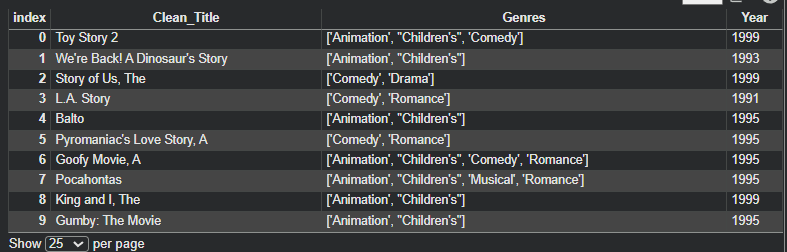



🧾 Conclusion

Phase 2 successfully developed a Content-Based Recommender System that:

Uses movie metadata (title, genres, year) to find textual similarity

Requires no user history to make predictions

Forms one half of the Hybrid Recommender System (to be combined with Collaborative Filtering in Phase 4)

This phase established a strong foundation for content similarity modeling, which will later blend with user preferences in the hybrid fusion layer.

